# Loan Status Prediction Neural Network
* We use tqdm for progress bars and also compute F1 score and accuracy.

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm

# 1. Load and Sample Data

In [2]:
df = pd.read_csv("../data/processed/processed_sample.csv")
df = df.sample(n=100_000, random_state=42)

In [4]:
df.head()

,Unnamed: 0,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,disbursement_method,debt_settlement_flag,issue_d_year,issue_d_month,earliest_cr_line_year,earliest_cr_line_month,last_pymnt_d_year,last_pymnt_d_month,last_credit_pull_d_year,last_credit_pull_d_month
359305,1620176,20000.0,60 months,16.49,D,3,10+ years,MORTGAGE,58500.0,Verified,...,Cash,N,2011,9,2001,12,2012.0,7.0,2016.0,10.0
198827,1792382,9000.0,36 months,17.10,C,5,10+ years,MORTGAGE,60000.0,Source Verified,...,Cash,N,2013,10,2000,12,2014.0,10.0,2018.0,11.0
387843,1021980,6000.0,36 months,7.89,A,5,10+ years,OWN,45000.0,Not Verified,...,Cash,N,2016,3,1996,7,2018.0,2.0,2019.0,3.0
165697,714602,5000.0,36 months,8.39,B,1,< 1 year,RENT,46000.0,Verified,...,Cash,N,2016,5,1994,8,2016.0,12.0,2017.0,10.0
405600,1295300,12900.0,60 months,21.18,E,3,10+ years,RENT,36000.0,Source Verified,...,Cash,N,2014,4,1989,2,2016.0,8.0,2016.0,10.0


In [5]:
df['loan_status'].value_counts()

loan_status
Fully Paid    79810
Default       20190
Name: count, dtype: int64

In [6]:
df_sample = df.sample(n=100_000, random_state=42)

 # 2. Separate Features and Target

In [7]:
target_col = 'loan_status'
X = df_sample.drop(columns=[target_col])
y = df_sample[target_col].values

# 3. Identify Numeric and Categorical Columns

In [8]:
categorical_cols = [col for col in X.columns if X[col].nunique() <= 20]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# 4. Preprocessing
Standardize numeric features and one-hot encode categorical features.


In [9]:
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X[numeric_cols])

In [10]:
# One-hot encode
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_categorical = ohe.fit_transform(X[categorical_cols])

In [11]:
X_processed = np.hstack([X_numeric, X_categorical])


In [12]:
# Encode target
e = LabelEncoder()
y_encoded = e.fit_transform(y)
num_classes = len(e.classes_)

In [13]:
# Convert to tensors
X_tensor = torch.tensor(X_processed, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# 5. Train/Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

# 6. Define Neural Network

In [16]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [17]:
model = SimpleNN(X_processed.shape[1], num_classes)

# 7. Loss and Optimizer

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#8. Training Loop with tqdm

Epoch 1/5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.0141


Epoch 2/5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.0126


Epoch 3/5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.0110


Epoch 4/5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.0098


Epoch 5/5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.0089


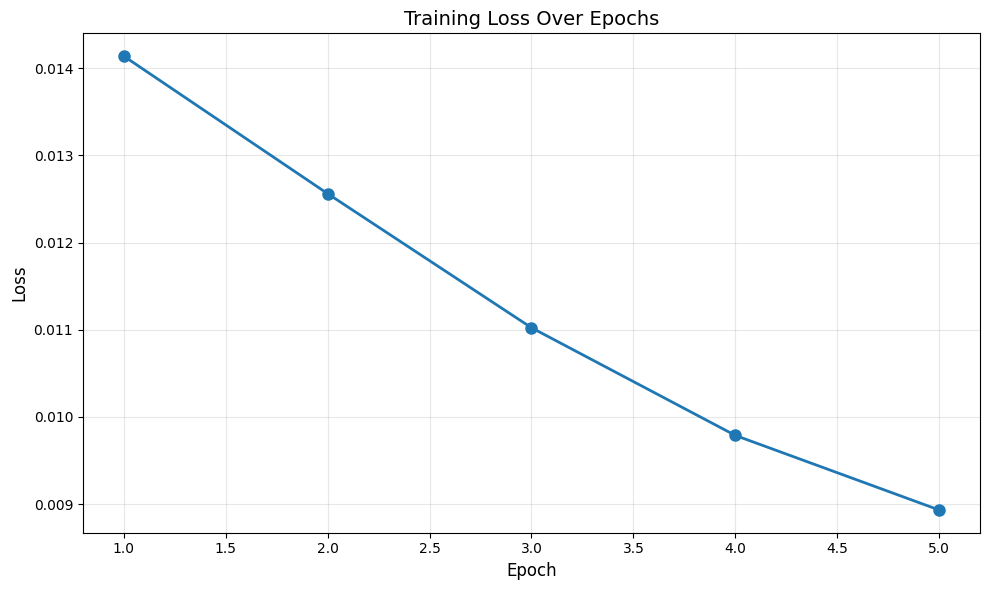

In [21]:
import matplotlib.pyplot as plt

epochs = 5
train_losses = []  # Store losses for plotting

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, marker='o', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#9. Evaluate Accuracy and F1 Score

In [22]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

model.eval()
y_pred_proba = []
y_true = []
with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        y_pred_proba.append(torch.softmax(preds, dim=1)[:, 1]) # Get probability of the positive class
        y_true.append(yb)

y_true = torch.cat(y_true).numpy()
y_pred_proba = torch.cat(y_pred_proba).numpy()
y_pred = (y_pred_proba > 0.5).astype(int)


acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_proba)

print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test AUC: {auc:.4f}")

Test Accuracy: 99.39%
Test F1 Score: 0.9962
Test AUC: 0.9986
